\# GAMMA...NEED TO LEARN MORE...
\# locally adaptive histogram equalization

## Gamma

> In the early days, the relationship between the voltage and the resulting brightness was characterized by $\gamma$, since
the formula was roughly $B = V^\gamma$ where gamma is about $2.2$. To compensate for this effect, the electronics in the TV camera would pre-map the sensed luminance Y through an inverse gamma $Y' = Y^{\frac{1}{\gamma}}$ with a typical value of $\frac{1}{\gamma} = 0.45$. This is so-called __Gamma Correlation__. One of the side effects is that noise introduced during transmission is squashed in the dark regions, which corresponds to the more noise-sensitive region of the visual system.

In [1]:
import cv2

In [2]:
import numpy as np

In [3]:
img = cv2.imread('dataset/Orgrimmar.jpg')

In [4]:
from matplotlib import pyplot as plt

<img src="dataset/Orgrimmar.jpg" alt="Orgrimmar" style="width: 600px;"/>

A useful api to deal with gamma_adjusting is 
- `cv2.LUT(src, lut[, dst[, interpolation]])`
which means that for an int8 array, a look-up table transformation will be given.

In [5]:
# Create the look up table
lut = lambda gamma = 2.2: np.uint8([ (i/ 255.0) ** (1/gamma) * 255 for i in range(256)])

(-0.5, 1919.5, 1079.5, -0.5)

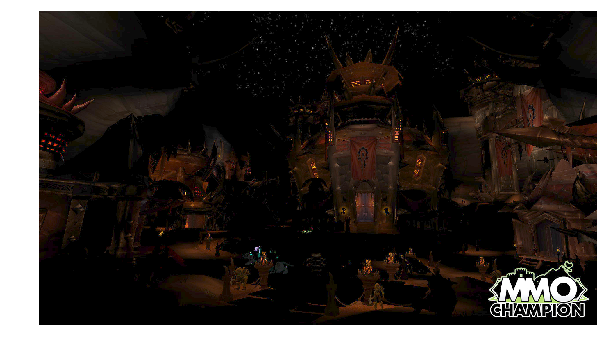

In [6]:
adjusted = cv2.LUT(img.astype(np.uint8), lut(1.8))
f, axis = plt.subplots(1, 1, figsize = (10, 10))
plt.imshow(cv2.cvtColor(adjusted.astype(np.uint8), cv2.COLOR_BGR2RGB))
axis.axis("off")

## Histogram equalization
One approach is to look at the darkest and brightest pixel values in an image and map them to pure black and pure white. Another approach might be to find the average value in the image, push it towards middle gray, and expand the range. Histogram will give us such statistic infomation. Alternatively, we can also find an intensity mapping function f(I) such that the resulting histogram is flat. This approach is called histogram equalization. The trick to finding such a mapping is the same one that people use to generate random samples from a probability density function, which is to first compute the cumulative distribution function. 

$$c(I) = \frac{1}{N}\sum_{i = 0}^I h(i) = c(I- 1) + \frac{1}{N} h(I)$$

We could apply $f(I) = c(I)$ to the original image. As we can see, the resulting histogram is flat; so is the resulting image. One way to compensate for this is to only partially compensate for the histogram unevenness, e.g., by using a mapping function $f(I) = \alpha c(I) + (1-\alpha)I$, which is a linear blend between the cumulative distribution function and
the identity transform (a straight line).

---

show that why $F(x)$ is uniformly distributed
We know that $f(x)$ is a $p.d.f.$, and $y = F(x)$ is a $c.d.f.$. Then we have 
$$x  = F ^ {-1} (y)$$
and 
$$\frac{dx}{dy} = (F^{-1})'(y) = \frac{1}{F'(x)} = \frac{1}{f(x)}$$
Then we have
$$\int f(x) dx = \int f(F^{-1}(y)) \frac{1}{f(x)} dy = \int 1 \cdot dy$$
so $g(Y)$ is uniformly distributed

---

In [10]:
imgHE = cv2.imread('dataset/test_HE.jpg')
B, G, R = cv2.split(imgHE)

In [ ]:
def histo

#### Exercise: Random Lighting

In [8]:
def random_lighting(img, intensity = 50):
    temp = img.copy()
    value = np.random.randint(intensity * -1, intensity, size=(3,))
    b, g, r = cv2.split(img)

    if value[0] < 0: 
        lim = - value[0]
        b[ b <= lim] = 0
        b[ b > lim] = b[ b > lim] + value[0]
    elif value[0] > 0:
        lim = 255 - value[0]
        b[ b >= lim] = 255
        b[ b < lim] = b[ b < lim] + value[0]
        
    if value[1] < 0: 
        lim = - value[1]
        g[ g <= lim] = 0
        g[ g > lim] = g[ g > lim] + value[1]
    elif value[1] > 0:
        lim = 255 - value[1]
        g[ g >= lim] = 255
        g[ g < lim] = g[ g < lim] + value[1]
    
    if value[2] < 0: 
        lim = - value[2]
        r[ r <= lim] = 0
        r[ r > lim] = r[ r > lim] + value[2]
    elif value[2] > 0:
        lim = 255 - value[2]
        r[ r >= lim] = 255
        r[ r < lim] = r[ r < lim] + value[2]
        
    return cv2.merge((b, g, r))

(-0.5, 1919.5, 1079.5, -0.5)

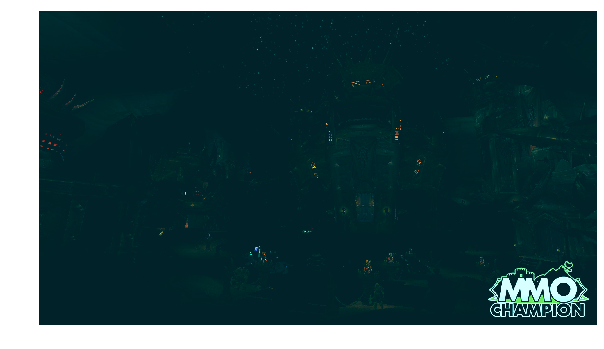

In [9]:
f, axis = plt.subplots(1, 1, figsize = (10, 10))
plt.imshow(cv2.cvtColor(random_lighting(img).astype(np.uint8), cv2.COLOR_BGR2RGB))
axis.axis("off")